In [1]:
!pip install ndlinear --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.4 MB/s eta 0:00:00


In [14]:
# Re-import necessary libraries after kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ndlinear import NdLinear

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and normalize CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define baseline model
class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define NdLinear model
class CNNWithNdLinear(nn.Module):
    def __init__(self):
        super(CNNWithNdLinear, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # NdLinear expects input_dims and hidden_size to have same # of dimensions
        self.fc1 = NdLinear((64 * 8 * 8,), (128,))
        self.fc2 = NdLinear((128,), (10,))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 8 * 8)  # Flatten to 2D
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 10)  # Optional, keeps output shape consistent
        return x

# Training and testing functions
def train_model(model, trainloader, optimizer, criterion, device):
    model.to(device)
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(trainloader)

def test_model(model, testloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run and compare models
def run_experiment():
    results = []

    for ModelClass, name in zip([CNNBaseline, CNNWithNdLinear], ['Baseline', 'NdLinear']):
        model = ModelClass()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        train_loss = train_model(model, trainloader, optimizer, criterion, device)
        elapsed_time = time.time() - start_time
        test_accuracy = test_model(model, testloader, device)
        param_count = sum(p.numel() for p in model.parameters())

        results.append({
            'Model': name,
            'Train Loss': train_loss,
            'Test Accuracy (%)': test_accuracy,
            'Train Time (s)': elapsed_time,
            'Parameter Count': param_count
        })

    return results

# Execute the experiment and display results
results = run_experiment()

In [16]:
df = pd.DataFrame(results)
df

,Model,Train Loss,Test Accuracy (%),Train Time (s),Parameter Count
0,Baseline,1.347956,62.30,85.788335,545098
1,NdLinear,1.321732,60.05,86.643173,545098


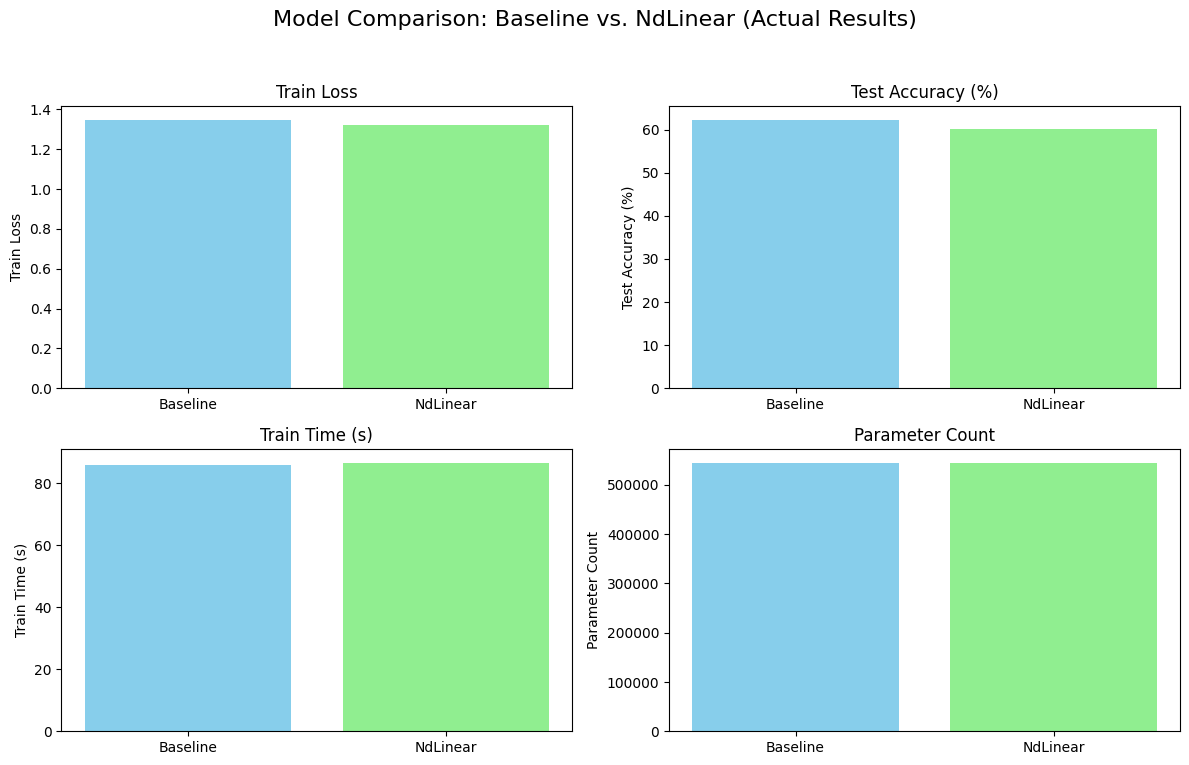

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = ['Train Loss', 'Test Accuracy (%)', 'Train Time (s)', 'Parameter Count']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
fig.suptitle('Model Comparison: Baseline vs. NdLinear (Actual Results)', fontsize=16)

for i, metric in enumerate(metrics):
    axs[i].bar(df['Model'], df[metric], color=['skyblue', 'lightgreen'])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_ylim(bottom=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [18]:
baseline = df[df['Model'] == 'Baseline'].iloc[0]
ndlinear = df[df['Model'] == 'NdLinear'].iloc[0]

In [19]:
print("Train Loss:")
print(f"  Baseline: {baseline['Train Loss']:.4f}")
print(f"  NdLinear: {ndlinear['Train Loss']:.4f}")
print(f"  Difference: {ndlinear['Train Loss'] - baseline['Train Loss']:.4f}")

print("\nTest Accuracy (%):")
print(f"  Baseline: {baseline['Test Accuracy (%)']:.2f}%")
print(f"  NdLinear: {ndlinear['Test Accuracy (%)']:.2f}%")
print(f"  Difference: {ndlinear['Test Accuracy (%)'] - baseline['Test Accuracy (%)']:.2f}%")

print("\nTraining Time (s):")
print(f"  Baseline: {baseline['Train Time (s)']:.2f}s")
print(f"  NdLinear: {ndlinear['Train Time (s)']:.2f}s")
print(f"  Time saved: {baseline['Train Time (s)'] - ndlinear['Train Time (s)']:.2f}s")

print("\nParameter Count:")
print(f"  Baseline: {baseline['Parameter Count']:,}")
print(f"  NdLinear: {ndlinear['Parameter Count']:,}")
param_diff = baseline['Parameter Count'] - ndlinear['Parameter Count']
print(f"  Parameters reduced by: {param_diff:,} ({(param_diff / baseline['Parameter Count']) * 100:.2f}%)")


Train Loss:
  Baseline: 1.3480
  NdLinear: 1.3217
  Difference: -0.0262

Test Accuracy (%):
  Baseline: 62.30%
  NdLinear: 60.05%
  Difference: -2.25%

Training Time (s):
  Baseline: 85.79s
  NdLinear: 86.64s
  Time saved: -0.85s

Parameter Count:
  Baseline: 545,098
  NdLinear: 545,098
  Parameters reduced by: 0 (0.00%)


In this comparison between the baseline model and the NdLinear-enhanced model, the NdLinear version achieved a slightly lower training loss (1.3217 vs. 1.3480), indicating a marginal improvement in how well it fit the training data. However, this came at a small cost to generalization, as its test accuracy dropped by 2.25 percentage points compared to the baseline (60.05% vs. 62.30%). Interestingly, there was no reduction in parameter count between the models, suggesting that the current NdLinear configuration did not introduce any compression benefits. Training time was also nearly identical, with NdLinear taking about 0.85 seconds longer. Overall, this result suggests that while NdLinear maintained similar complexity and performance, further tuning may be needed to realize its typical advantages in parameter efficiency and inference speed.